## **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
from IPython.display import display

In [ ]:
npz_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all"

In [ ]:
INCLUDE_SILENCE = True
SILENCE_CLASS = 20
NUM_FRETS = 20
NUM_CLASSES = NUM_FRETS + int(INCLUDE_SILENCE)

In [ ]:
!pip install tqdm

## **Data Inspect**

In [ ]:
import numpy as np

npz_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz"
data = np.load(npz_path, allow_pickle=True)
print(data.files)  # ['audio', 'tablature', 'onsets', ...]

['track', 'fs', 'audio', 'tablature', 'tablature_adj', 'tablature_rel', 'onsets', 'notes', 'offsets', 'multi_pitch', 'pitch_list', 'hcqt', 'cqt', 'mel', 'stft', 'power']


In [ ]:
import os

npz_path_list = [
    os.path.join(npz_dir, fname)
    for fname in sorted(os.listdir(npz_dir))
    if fname.endswith(".npz")
]

In [ ]:
import numpy as np

def inspect_npz_structure(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    print(f"📁 Analyzing file: {os.path.basename(npz_path)}\n")

    summary = []

    for key in data.files:
        arr = data[key]
        info = {
            "Key": key,
            "Shape": arr.shape,
            "Dtype": arr.dtype,
            "Min": np.min(arr) if np.issubdtype(arr.dtype, np.number) else "-",
            "Max": np.max(arr) if np.issubdtype(arr.dtype, np.number) else "-",
        }
        summary.append(info)

    import pandas as pd
    df = pd.DataFrame(summary)
    return df

In [ ]:
npz_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN1-129-Eb_comp.npz"

df = inspect_npz_structure(npz_path)
display(df)

📁 Analyzing file: 00_BN1-129-Eb_comp.npz



,Key,Shape,Dtype,Min,Max
0,track,(),<U18,-,-
1,fs,(),int64,22050,22050
2,audio,"(492253,)",float32,-9.457,9.383601
3,tablature,"(6, 962)",int64,-1,8
4,tablature_adj,"(120, 962)",float64,0.0,1.0
5,tablature_rel,"(120, 962)",float64,-0.5,0.5
6,onsets,"(6, 44, 962)",float64,0.0,1.0
7,notes,"(6, 2)",object,-,-
8,offsets,"(6, 44, 962)",float64,0.0,1.0
9,multi_pitch,"(6, 44, 962)",float64,0.0,1.0


In [ ]:
import numpy as np

npz = np.load(npz_path, allow_pickle=True)
adj = npz["tablature_adj"]  # shape: (120, 962)

print("tablature_adj shape:", adj.shape)
print("Value range:", adj.min(), "-", adj.max())

for t in range(5):
    active = np.where(adj[:, t] > 0.5)[0]
    print(f"t={t}: active indices →", active)

tablature_adj shape: (120, 962)
Value range: 0.0 - 1.0
t=0: active indices → []
t=1: active indices → []
t=2: active indices → []
t=3: active indices → [26 67 86]
t=4: active indices → [26 67 86]


In [ ]:
onsets = npz["onsets"]  # shape: (6, 44, 962)

total_onsets = np.sum(onsets)
print(f"Total onsets: {total_onsets}")

for t in range(10):
    string, fret = np.where(onsets[:, :, t] > 0.5)
    if len(string) > 0:
        print(f"t={t}:")
        for s, f in zip(string, fret):
            print(f"  String {s}, Fret {f}")

Total onsets: 133.0
t=2:
  String 1, Fret 11
  String 3, Fret 22
  String 4, Fret 25


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

def analyze_onset_distribution(npz_paths, max_fret=44, num_strings=6):
    """
    Verilen .npz dosyalarından tüm onsets verisini analiz eder.
    Her bir (fret, string) kombinasyonu için kaç kez onset gerçekleşmiş,
    bunu hesaplar ve dikey DataFrame olarak döner.

    Returns:
        pandas.DataFrame [Fret x String] → Count
    """
    onset_counter = Counter()

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        if "onsets" not in data:
            continue
        onsets = data["onsets"]  # Shape: (6, Fret, Time)

        for s in range(num_strings):
            for f in range(min(onsets.shape[1], max_fret)):
                count = int(np.sum(onsets[s, f] == 1.0))
                if count > 0:
                    onset_counter[(f, s)] += count

    # Veriyi Fret x String formatında dök
    df = pd.DataFrame(index=[f"Fret {f}" for f in range(max_fret)],
                      columns=[f"String {s+1}" for s in range(num_strings)],
                      dtype=int)

    for (f, s), c in onset_counter.items():
        df.at[f"Fret {f}", f"String {s+1}"] = c

    df.fillna(0, inplace=True)
    print("📊 Total Onset Distribution (Fret x String) Computed")
    return df

In [ ]:
df = analyze_onset_distribution(npz_path_list)

📊 Total Onset Distribution (Fret x String) Computed


In [ ]:
display(df)

,String 1,String 2,String 3,String 4,String 5,String 6
Fret 0,626.0,0.0,0.0,0.0,0.0,0.0
Fret 1,516.0,0.0,0.0,0.0,0.0,0.0
Fret 2,527.0,0.0,0.0,0.0,0.0,0.0
Fret 3,654.0,0.0,0.0,0.0,0.0,0.0
Fret 4,740.0,0.0,0.0,0.0,0.0,0.0
Fret 5,425.0,698.0,0.0,0.0,0.0,0.0
Fret 6,552.0,323.0,0.0,0.0,0.0,0.0
Fret 7,225.0,915.0,0.0,0.0,0.0,0.0
Fret 8,158.0,1098.0,0.0,0.0,0.0,0.0
Fret 9,123.0,1551.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
import pandas as pd

def inspect_feature_tensors(npz_path, feature_keys=None):
    """
    Belirtilen .npz dosyasındaki özniteliklerin temel istatistiklerini döndürür.

    Args:
        npz_path (str): .npz dosyasının yolu
        feature_keys (list): Kontrol edilecek anahtarlar (varsayılan: hcqt, cqt, mel, stft, power)

    Returns:
        pd.DataFrame: Feature adı, shape, min, max, dtype
    """
    if feature_keys is None:
        feature_keys = ['hcqt', 'cqt', 'mel', 'stft', 'power']

    data = np.load(npz_path, allow_pickle=True)
    stats = []

    for key in feature_keys:
        if key not in data:
            continue
        tensor = data[key]
        stats.append({
            "Feature": key,
            "Shape": tensor.shape,
            "Min": float(np.min(tensor)),
            "Max": float(np.max(tensor)),
            "Dtype": str(tensor.dtype)
        })

    return pd.DataFrame(stats)

In [ ]:
df = inspect_feature_tensors(npz_path)
display(df)

,Feature,Shape,Min,Max,Dtype
0,hcqt,"(6, 144, 962)",0.000000,1.0,float32
1,cqt,"(1, 192, 962)",0.000000,1.0,float32
2,mel,"(1, 229, 962)",0.000000,1.0,float32
3,stft,"(1, 1025, 962)",0.000000,1.0,float32
4,power,"(962,)",-66.271255,0.0,float32


In [ ]:
import numpy as np
import librosa

def analyze_audio(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    audio = data['audio']
    sr = data['fs'].item()

    duration_sec = len(audio) / sr
    rms = np.sqrt(np.mean(audio ** 2))
    peak = np.max(np.abs(audio))
    db = 20 * np.log10(peak + 1e-10)

    print(f"🎧 Audio shape: {audio.shape}")
    print(f"📏 Duration: {duration_sec:.2f} sec")
    print(f"🧱 Sampling Rate: {sr}")
    print(f"📈 RMS: {rms:.4f}, Peak: {peak:.4f}, dBFS: {db:.2f}")

    silence_ratio = np.mean(np.abs(audio) < 0.01)
    print(f"🧘 Silence Ratio: {silence_ratio:.2%}")

    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    if len(pitches) > 0:
        print(f"🎵 Pitch range: {pitches.min():.2f} Hz - {pitches.max():.2f} Hz")
    else:
        print("⚠️ Pitch tracking failed (low energy or silence)")

    return audio, sr

In [ ]:
analyze_audio(npz_path)

🎧 Audio shape: (492253,)
📏 Duration: 22.32 sec
🧱 Sampling Rate: 22050
📈 RMS: 1.0000, Peak: 9.4570, dBFS: 19.52
🧘 Silence Ratio: 1.61%
🎵 Pitch range: 146.31 Hz - 3972.73 Hz


(array([ 0.31945464,  0.47844216,  0.41357127, ..., -0.11243188,
        -0.101813  , -0.09873164], dtype=float32),
 22050)

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

def compute_per_string_class_distribution(npz_paths, num_strings=6, include_silence=True):
    """
    Her tel (string) için fret sınıf dağılımı çıkarır.
    Sessizlik (-1) sınıfı korunur ve DataFrame'de 'Class -1 (silence)' olarak gösterilir.
    """
    counts = [Counter() for _ in range(num_strings)]

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        if "tablature" not in data:
            continue

        tab = data["tablature"]  # [6, T]

        for s in range(num_strings):
            frets = tab[s]
            if not include_silence:
                frets = frets[frets != -1]
            counts[s].update(frets.tolist())

    # Tüm görülen fret sınıflarını topla (sessizlik -1 dahil)
    all_frets = set()
    for c in counts:
        all_frets.update(c.keys())
    sorted_classes = sorted(all_frets)  # -1 önce gelir

    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in sorted_classes:
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i} (silence)" if i == -1 else f"Class {i}" for i in sorted_classes]

    print("🎯 Class Distribution per String (Count + Ratio):")
    return df

In [ ]:
class_distribution_df = compute_per_string_class_distribution(npz_path_list, include_silence=INCLUDE_SILENCE)
display(class_distribution_df)

🎯 Class Distribution per String (Count + Ratio):


,String 1,String 2,String 3,String 4,String 5,String 6
Class -1 (silence),388689 (0.8225),336007 (0.7110),285755 (0.6047),273338 (0.5784),301872 (0.6388),386913 (0.8188)
Class 0,14633 (0.0310),9173 (0.0194),10788 (0.0228),11509 (0.0244),11671 (0.0247),9942 (0.0210)
Class 1,10799 (0.0229),5185 (0.0110),2122 (0.0045),10804 (0.0229),12022 (0.0254),6141 (0.0130)
Class 2,8937 (0.0189),15651 (0.0331),19238 (0.0407),15689 (0.0332),12583 (0.0266),5738 (0.0121)
Class 3,12138 (0.0257),18968 (0.0401),25406 (0.0538),20618 (0.0436),15071 (0.0319),7592 (0.0161)
Class 4,12493 (0.0264),24053 (0.0509),18142 (0.0384),17691 (0.0374),17007 (0.0360),9004 (0.0191)
Class 5,5996 (0.0127),11470 (0.0243),17533 (0.0371),18739 (0.0397),14573 (0.0308),8299 (0.0176)
Class 6,10385 (0.0220),22722 (0.0481),29131 (0.0616),31625 (0.0669),23594 (0.0499),10641 (0.0225)
Class 7,3384 (0.0072),9289 (0.0197),15560 (0.0329),21732 (0.0460),13770 (0.0291),5093 (0.0108)
Class 8,2450 (0.0052),11714 (0.0248),23350 (0.0494),19435 (0.0411),18591 (0.0393),8291 (0.0175)


In [ ]:
def build_resample_strategy(distribution_df,
                            low_percentile=20, mid_percentile=40, high_percentile=85):
    strategy = {}
    all_counts = []

    for class_idx, row in distribution_df.iterrows():
        fret_str = class_idx.replace("Class", "").split()[0]
        fret = int(fret_str) if fret_str != "-1" else -1

        for s_idx, cell in enumerate(row):
            try:
                count = int(cell.split(" ")[0])
                if fret != -1:
                    all_counts.append(count)
            except:
                continue

    # Dinamik threshold'ları belirle
    low_thresh = np.percentile(all_counts, low_percentile)
    mid_thresh = np.percentile(all_counts, mid_percentile)
    high_thresh = np.percentile(all_counts, high_percentile)

    for class_idx, row in distribution_df.iterrows():
        fret_str = class_idx.replace("Class", "").split()[0]
        fret = int(fret_str) if fret_str != "-1" else -1

        for s_idx, cell in enumerate(row):
            try:
                count = int(cell.split(" ")[0])
            except:
                continue

            key = (s_idx, fret)

            if fret == -1:
                strategy[key] = "silence"
            elif count == 0:
                strategy[key] = "ignore"
            elif count < low_thresh:
                strategy[key] = "upsample_hard"
            elif count < mid_thresh:
                strategy[key] = "upsample"
            elif count > high_thresh:
                strategy[key] = "downsample"
            else:
                strategy[key] = "leave"

    print(f"🔢 Thresholds | low: {low_thresh:.1f}, mid: {mid_thresh:.1f}, high: {high_thresh:.1f}")
    return strategy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fret_distribution_histogram(distribution_df, silence_fret=20,
                                     low_percentile=25, mid_percentile=40, high_percentile=80):
    all_counts = []

    # Dağılım içinden sayısal count'ları çıkar
    for class_idx, row in distribution_df.iterrows():
        fret = int(class_idx.replace("Class", "").split()[0])
        if fret == silence_fret:
            continue  # sessiz sınıfı atla

        for s_idx, cell in enumerate(row):
            try:
                count = int(cell.split(" ")[0])
                all_counts.append(count)
            except:
                continue

    # Threshold'ları hesapla
    low_thresh = np.percentile(all_counts, low_percentile)
    mid_thresh = np.percentile(all_counts, mid_percentile)
    high_thresh = np.percentile(all_counts, high_percentile)

    # Histogram çiz
    plt.figure(figsize=(10, 5))
    plt.hist(all_counts, bins=100, log=True, color='gray', edgecolor='black')
    plt.axvline(low_thresh, color='blue', linestyle='--', label=f'low ({low_thresh:.1f})')
    plt.axvline(mid_thresh, color='orange', linestyle='--', label=f'mid ({mid_thresh:.1f})')
    plt.axvline(high_thresh, color='red', linestyle='--', label=f'high ({high_thresh:.1f})')
    plt.title("🎸 Tüm Fret-String Kombinasyonlarının Dağılımı")
    plt.xlabel("Örnek Sayısı")
    plt.ylabel("Frekans (log)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"🔢 Thresholds | low: {low_thresh:.1f}, mid: {mid_thresh:.1f}, high: {high_thresh:.1f}")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


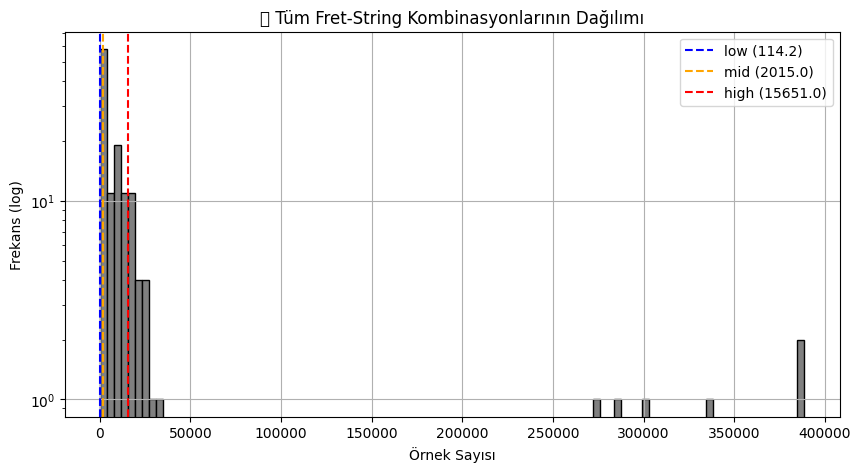

🔢 Thresholds | low: 114.2, mid: 2015.0, high: 15651.0


In [ ]:
plot_fret_distribution_histogram(class_distribution_df)

In [ ]:
from pprint import pprint

strategy_map = build_resample_strategy(class_distribution_df)
pprint({k: v for k, v in strategy_map.items() if v != "leave"})

🔢 Thresholds | low: 25.8, mid: 1886.0, high: 15886.7
{(0, -1): 'silence',
 (0, 9): 'upsample',
 (0, 10): 'upsample',
 (0, 11): 'upsample',
 (0, 12): 'upsample',
 (0, 13): 'ignore',
 (0, 14): 'upsample_hard',
 (0, 15): 'ignore',
 (0, 16): 'ignore',
 (0, 17): 'ignore',
 (0, 18): 'ignore',
 (0, 19): 'ignore',
 (1, -1): 'silence',
 (1, 3): 'downsample',
 (1, 4): 'downsample',
 (1, 6): 'downsample',
 (1, 11): 'upsample',
 (1, 12): 'upsample',
 (1, 13): 'upsample_hard',
 (1, 14): 'ignore',
 (1, 15): 'ignore',
 (1, 16): 'ignore',
 (1, 17): 'ignore',
 (1, 18): 'ignore',
 (1, 19): 'ignore',
 (2, -1): 'silence',
 (2, 2): 'downsample',
 (2, 3): 'downsample',
 (2, 4): 'downsample',
 (2, 5): 'downsample',
 (2, 6): 'downsample',
 (2, 8): 'downsample',
 (2, 13): 'upsample',
 (2, 14): 'upsample',
 (2, 15): 'upsample_hard',
 (2, 16): 'upsample_hard',
 (2, 17): 'upsample_hard',
 (2, 18): 'upsample',
 (2, 19): 'upsample_hard',
 (3, -1): 'silence',
 (3, 3): 'downsample',
 (3, 4): 'downsample',
 (3, 5): 'd

In [ ]:
import os
import numpy as np

def get_upsample_relevant_files(npz_paths, strategy, silence_class=20):
    upsample_keys = [k for k, v in strategy.items() if v.startswith("upsample")]
    relevant_files = []

    for path in npz_paths:
        data = np.load(path, allow_pickle=True)
        tablature = data["tablature"]  # shape: (6, T)
        has_target = False

        for (s, f) in upsample_keys:
            fret = f if f != silence_class else -1
            if np.any(tablature[s] == fret):
                has_target = True
                break

        if has_target:
            relevant_files.append(path)

    return relevant_files


In [ ]:
upsample_files = get_upsample_relevant_files(npz_path_list, strategy_map)

print(f"🎯 Toplam {len(upsample_files)} dosyada upsample yapılabilir.")
for f in upsample_files:
    print("📄", os.path.basename(f))

🎯 Toplam 124 dosyada upsample yapılabilir.
📄 00_BN2-131-B_solo.npz
📄 00_BN2-166-Ab_solo.npz
📄 00_BN3-154-E_comp.npz
📄 00_Funk1-114-Ab_solo.npz
📄 00_Funk1-97-C_comp.npz
📄 00_Funk2-119-G_comp.npz
📄 00_Funk3-112-C#_comp.npz
📄 00_Funk3-98-A_comp.npz
📄 00_Funk3-98-A_solo.npz
📄 00_Jazz1-130-D_comp.npz
📄 00_Jazz1-200-B_solo.npz
📄 00_Jazz2-110-Bb_solo.npz
📄 00_Jazz2-187-F#_solo.npz
📄 00_Jazz3-137-Eb_comp.npz
📄 00_Jazz3-137-Eb_solo.npz
📄 00_Jazz3-150-C_comp.npz
📄 00_Jazz3-150-C_solo.npz
📄 00_Rock1-130-A_solo.npz
📄 00_Rock1-90-C#_comp.npz
📄 00_Rock2-85-F_solo.npz
📄 00_Rock3-117-Bb_comp.npz
📄 00_Rock3-148-C_solo.npz
📄 00_SS1-68-E_comp.npz
📄 00_SS1-68-E_solo.npz
📄 00_SS2-88-F_solo.npz
📄 00_SS3-84-Bb_comp.npz
📄 00_SS3-98-C_solo.npz
📄 01_BN1-147-Gb_solo.npz
📄 01_BN2-131-B_solo.npz
📄 01_BN3-119-G_solo.npz
📄 01_BN3-154-E_solo.npz
📄 01_Funk1-97-C_solo.npz
📄 01_Funk2-108-Eb_solo.npz
📄 01_Funk2-119-G_solo.npz
📄 01_Funk3-112-C#_comp.npz
📄 01_Jazz1-200-B_solo.npz
📄 01_Jazz2-110-Bb_solo.npz
📄 01_Jazz3-137-E

In [ ]:
from collections import Counter
import numpy as np

def adjust_strategy_for_file(npz_path: str,
                             global_strategy: dict,
                             low_threshold: int = 10) -> dict:
    data = np.load(npz_path, allow_pickle=True)
    tablature = data["tablature"]  # shape: (6, T)
    local_counter = Counter()

    for s in range(tablature.shape[0]):
        for t in range(tablature.shape[1]):
            f = tablature[s, t]
            local_counter[(s, f)] += 1

    new_strategy = {}
    for key, global_label in global_strategy.items():
        local_count = local_counter.get(key, 0)

        if global_label in ["upsample", "upsample_hard"]:
            new_strategy[key] = global_label if local_count > 0 else "ignore"

        elif global_label == "downsample":
            new_strategy[key] = "downsample" if local_count >= low_threshold else "leave"

        else:
            new_strategy[key] = global_label  # silence, ignore, leave

    # ✅ Her string için mutlaka (s, -1) stratejisi olsun (silence)
    for s in range(tablature.shape[0]):
        if (s, -1) not in new_strategy:
            new_strategy[(s, -1)] = "silence"

    return new_strategy

In [ ]:
upsample_npz = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN2-131-B_solo.npz"

In [ ]:
data = dict(np.load(upsample_npz, allow_pickle=True))

for key in data:
    print(f"{key}: shape = {data[key].shape}, dtype = {data[key].dtype}")

track: shape = (), dtype = <U17
fs: shape = (), dtype = int64
audio: shape = (646206,), dtype = float32
tablature: shape = (6, 1263), dtype = int64
tablature_adj: shape = (120, 1263), dtype = float64
tablature_rel: shape = (120, 1263), dtype = float64
onsets: shape = (6, 44, 1263), dtype = float64
notes: shape = (6, 2), dtype = object
offsets: shape = (6, 44, 1263), dtype = float64
multi_pitch: shape = (6, 44, 1263), dtype = float64
pitch_list: shape = (6, 2), dtype = object
hcqt: shape = (6, 144, 1263), dtype = float32
cqt: shape = (1, 192, 1263), dtype = float32
mel: shape = (1, 229, 1263), dtype = float32
stft: shape = (1, 1025, 1263), dtype = float32
power: shape = (1263,), dtype = float32


In [ ]:
local_strategy = adjust_strategy_for_file(upsample_npz, strategy_map)
from collections import Counter
summary = Counter(local_strategy.values())
print(summary)

Counter({'leave': 71, 'ignore': 40, 'upsample': 7, 'silence': 6, 'downsample': 1, 'upsample_hard': 1})


In [ ]:
pprint({k: v for k, v in local_strategy.items() if v != "leave"})

{(0, -1): 'silence',
 (0, 9): 'ignore',
 (0, 10): 'ignore',
 (0, 11): 'ignore',
 (0, 12): 'ignore',
 (0, 13): 'ignore',
 (0, 14): 'ignore',
 (0, 15): 'ignore',
 (0, 16): 'ignore',
 (0, 17): 'ignore',
 (0, 18): 'ignore',
 (0, 19): 'ignore',
 (1, -1): 'silence',
 (1, 11): 'ignore',
 (1, 12): 'ignore',
 (1, 13): 'ignore',
 (1, 14): 'ignore',
 (1, 15): 'ignore',
 (1, 16): 'ignore',
 (1, 17): 'ignore',
 (1, 18): 'ignore',
 (1, 19): 'ignore',
 (2, -1): 'silence',
 (2, 8): 'downsample',
 (2, 13): 'ignore',
 (2, 14): 'ignore',
 (2, 15): 'ignore',
 (2, 16): 'ignore',
 (2, 17): 'ignore',
 (2, 18): 'ignore',
 (2, 19): 'ignore',
 (3, -1): 'silence',
 (3, 13): 'ignore',
 (3, 14): 'upsample',
 (3, 15): 'ignore',
 (3, 16): 'ignore',
 (3, 17): 'ignore',
 (3, 18): 'ignore',
 (3, 19): 'ignore',
 (4, -1): 'silence',
 (4, 14): 'upsample',
 (4, 15): 'upsample',
 (4, 16): 'ignore',
 (4, 17): 'ignore',
 (4, 18): 'ignore',
 (4, 19): 'ignore',
 (5, -1): 'silence',
 (5, 12): 'upsample',
 (5, 13): 'upsample',
 (

## **Applying Balancing**

In [ ]:
from tqdm import tqdm
import numpy as np
import random

def apply_resampling_strategy_npz(npz_path, local_strategy, context=5):
    data = np.load(npz_path, allow_pickle=True)
    hcqt = data['hcqt']
    tablature = data['tablature']

    segments, strings, frets, coords = [], [], [], []

    def extract_segment(s, t):
        start = max(t - context, 0)
        end = min(t + context + 1, hcqt.shape[2])
        seg = hcqt[s, :, start:end]
        if seg.shape[1] < 2 * context + 1:
            pad_left = max(0, context - t)
            pad_right = max(0, (t + context + 1) - hcqt.shape[2])
            seg = np.pad(seg, ((0, 0), (pad_left, pad_right)), mode='constant')
        return seg

    for (s, f), action in tqdm(local_strategy.items(), desc="🟢 Resampling segments by strategy"):
        frame_ids = np.where(tablature[s, :] == f)[0]
        count = len(frame_ids)
        if count == 0:
            continue

        if action == "leave":
            continue
        elif action == "upsample":
            target_count = count * 2
        elif action == "upsample_hard":
            target_count = count * 3
        elif action in ["downsample", "silence"]:
            target_count = max(1, int(count * 0.7))
        else:
            continue

        if action in ["downsample", "silence"]:
            selected_ids = list(frame_ids) if count <= target_count else random.sample(list(frame_ids), target_count)
        elif action in ["upsample", "upsample_hard"]:
            repeats = target_count // count
            remainder = target_count % count
            selected_ids = list(frame_ids) * repeats + random.sample(list(frame_ids), remainder)

        for idx in selected_ids:
            seg = extract_segment(s, idx)
            if seg is not None:
                segments.append(seg)
                strings.append(s)
                frets.append(f)
                coords.append((s, idx))

    if not segments:
        print("⚠️ Hiç segment bulunamadı.")
        return None

    return {
        'hcqt': np.stack(segments),
        'string': np.array(strings),
        'fret': np.array(frets),
        'selected_coords': np.array(coords)
    }

In [ ]:
from tqdm import tqdm
import numpy as np

def merge_original_and_resampled_npz(npz_path, resampled_data, local_strategy, context=5):
    data = np.load(npz_path, allow_pickle=True)
    hcqt = data['hcqt']
    tablature = data['tablature']

    segments, strings, frets, coords = [], [], [], []

    def extract_segment(s, t):
        start = max(t - context, 0)
        end = min(t + context + 1, hcqt.shape[2])
        seg = hcqt[s, :, start:end]
        if seg.shape[1] < 2 * context + 1:
            pad_left = max(0, context - t)
            pad_right = max(0, (t + context + 1) - hcqt.shape[2])
            seg = np.pad(seg, ((0, 0), (pad_left, pad_right)), mode='constant')
        return seg

    T = tablature.shape[1]
    for s in tqdm(range(tablature.shape[0]), desc="🟡 Merging original segments"):
        for t in range(T):
            f = tablature[s, t]

            if f == -1:
                continue

            else:
                action = local_strategy.get((s, f), "leave")
                if action != "leave":
                    continue

            seg = extract_segment(s, t)
            if seg is not None:
                segments.append(seg)
                strings.append(s)
                frets.append(f)
                coords.append((s, t))

    orig_hcqt = np.stack(segments, axis=0) if segments else np.empty((0, hcqt.shape[1], 2 * context + 1))
    orig_string = np.array(strings)
    orig_fret = np.array(frets)
    orig_coords = np.array(coords)

    return {
        'hcqt': np.concatenate([orig_hcqt, resampled_data['hcqt']], axis=0),
        'string': np.concatenate([orig_string, resampled_data['string']]),
        'fret': np.concatenate([orig_fret, resampled_data['fret']]),
        'selected_coords': np.concatenate([orig_coords, resampled_data['selected_coords']])
    }


In [ ]:
def extract_segment_1d(arr, center_idx, context):
    start = max(center_idx - context, 0)
    end = min(center_idx + context + 1, len(arr))
    segment = arr[start:end]
    pad_left = max(0, context - center_idx)
    pad_right = max(0, (center_idx + context + 1) - len(arr))
    segment = np.pad(segment, (pad_left, pad_right), mode='constant')
    return segment

def extract_segment_2d(arr2d, center_idx, context):
    start = max(center_idx - context, 0)
    end = min(center_idx + context + 1, arr2d.shape[1])
    seg = arr2d[:, start:end]
    pad_left = max(0, context - center_idx)
    pad_right = max(0, (center_idx + context + 1) - arr2d.shape[1])
    seg = np.pad(seg, ((0, 0), (pad_left, pad_right)), mode='constant')
    return seg

In [ ]:
from tqdm import tqdm

def extract_all_segments(data, selected_coords, context=5):
    hcqt_segments, power_segments = [], []
    cqt_segments, mel_segments, stft_segments, audio_segments = [], [], [], []

    hop = 512

    for (s, t) in tqdm(selected_coords, desc="🔵 Extracting all feature segments"):
        hcqt_seg = extract_segment_2d(data['hcqt'][s], t, context)
        power_seg = extract_segment_1d(data['power'], t, context)
        cqt_seg = extract_segment_2d(data['cqt'][0], t, context)
        mel_seg = extract_segment_2d(data['mel'][0], t, context)
        stft_seg = extract_segment_2d(data['stft'][0], t, context)

        audio_start = t * hop
        audio_seg = extract_segment_1d(data['audio'], audio_start, context * hop)

        hcqt_segments.append(hcqt_seg)
        power_segments.append(power_seg)
        cqt_segments.append(cqt_seg)
        mel_segments.append(mel_seg)
        stft_segments.append(stft_seg)
        audio_segments.append(audio_seg)

    return {
        'hcqt': np.stack(hcqt_segments),
        'power': np.stack(power_segments),
        'cqt': np.stack(cqt_segments),
        'mel': np.stack(mel_segments),
        'stft': np.stack(stft_segments),
        'audio': np.stack(audio_segments)
    }

In [ ]:
def clean_notes_structure(notes_raw):
    fixed = []
    for entry in notes_raw:
        # kontrol: ['i', (pitches, intervals)] formu
        if isinstance(entry, np.ndarray) and len(entry) == 2 and isinstance(entry[1], tuple):
            fixed.append(entry[1])  # 🎯 tuple kısmını al
        else:
            fixed.append((np.array([], dtype=np.float32), np.zeros((0, 2), dtype=np.float32)))
    return fixed  # numpy array'e gerek yok

In [ ]:
def filter_notes(notes_array, selected_coords, sr=22050, hop=512, tol_sec=0.025):
    """
    selected_coords'e göre sadece ilgili frame'lerdeki notaları bırak.
    """
    selected_ts = set(t for _, t in selected_coords)
    tol = int((tol_sec * sr) / hop)  # frame toleransı

    filtered_notes = []

    for note in notes_array:
        if not isinstance(note, tuple) or len(note) != 2:
            filtered_notes.append((np.array([]), np.array([])))
            continue

        onsets, frets = note
        if len(onsets) == 0 or len(frets) == 0:
            filtered_notes.append((np.array([]), np.array([])))
            continue

        matched_onsets, matched_frets = [], []
        for o, f in zip(onsets, frets):
            if any(abs(o - t) <= tol for t in selected_ts):
                matched_onsets.append(o)
                matched_frets.append(f)

        filtered_notes.append((np.array(matched_onsets), np.array(matched_frets)))

    return filtered_notes  # 🔁 NOT: artık np.array değil, sadece list

In [ ]:
def convert_cleaned_notes_to_pitch_list(cleaned_notes, num_strings=6):
    pitch_list = []

    for i in range(num_strings):
        pitch_data = cleaned_notes[i]

        if isinstance(pitch_data, tuple) and len(pitch_data) == 2:
            pitches = np.array(pitch_data[0], dtype=np.float32)
            intervals = np.array(pitch_data[1], dtype=np.float32)

            if intervals.ndim == 2 and intervals.shape[1] == 2 and len(pitches) == intervals.shape[0]:
                pitch_list.append((pitches, intervals))
            else:
                pitch_list.append((np.array([], dtype=np.float32), np.zeros((0, 2), dtype=np.float32)))
        else:
            pitch_list.append((np.array([], dtype=np.float32), np.zeros((0, 2), dtype=np.float32)))

    return pitch_list  # 🛑 NumPy array'e çevirme, sadece list olarak bırak

In [ ]:
def filter_pitch_list(pitch_list_array, selected_coords, sr=22050, hop=512, tol_sec=0.025):
    selected_ts = set(t for _, t in selected_coords)
    tol = tol_sec * sr / hop

    filtered_pitch_list = []

    for pitch_tuple in pitch_list_array:
        if not isinstance(pitch_tuple, tuple) or len(pitch_tuple) != 2:
            filtered_pitch_list.append((np.array([]), np.zeros((0, 2))))
            continue

        raw_intervals = pitch_tuple[1]
        if not isinstance(raw_intervals, (list, np.ndarray)):
            raw_intervals = []

        # Sadece 2 elemanlı olan tuple/liste'leri al
        clean_intervals = [list(i) for i in raw_intervals if isinstance(i, (list, tuple, np.ndarray)) and len(i) == 2]

        pitches = np.array(pitch_tuple[0], dtype=np.float32)
        intervals = np.array(clean_intervals, dtype=np.float32).reshape(-1, 2)

        if len(pitches) == 0 or intervals.shape[0] == 0:
            filtered_pitch_list.append((np.array([]), np.zeros((0, 2))))
            continue

        matched_pitches = []
        matched_intervals = []

        for p, (start, end) in zip(pitches, intervals):
            start_frame = start * sr / hop
            end_frame = end * sr / hop
            if any(abs(t - start_frame) <= tol or abs(t - end_frame) <= tol for t in selected_ts):
                matched_pitches.append(p)
                matched_intervals.append([start, end])

        matched_pitches = np.array(matched_pitches, dtype=np.float32)
        matched_intervals = np.array(matched_intervals, dtype=np.float32).reshape(-1, 2)

        filtered_pitch_list.append((matched_pitches, matched_intervals))

    return filtered_pitch_list

In [ ]:
def reconstruct_adj_rel(original_data, selected_coords):
    adj_out = np.zeros_like(original_data['tablature_adj'])
    rel_out = np.zeros_like(original_data['tablature_rel'])
    for (s, t) in selected_coords:
        adj_out[:, t] = original_data['tablature_adj'][:, t]
        rel_out[:, t] = original_data['tablature_rel'][:, t]
    return adj_out, rel_out

In [ ]:
def build_frame_level_npz_from_segments(merged_virtual_npz, test_data, context=5):
    import numpy as np
    from tqdm import tqdm

    sr = test_data["fs"].item()
    hop = 512
    num_strings = 6

    selected_coords = merged_virtual_npz["selected_coords"]
    frets = merged_virtual_npz["fret"]
    num_segments = len(selected_coords)
    max_time = max(t for (_, t) in selected_coords) + 1

    output = {
        "track": test_data["track"],
        "fs": test_data["fs"],
        "string": np.zeros((num_segments,), dtype=np.int64),
        "fret": np.zeros((num_segments,), dtype=np.int64),
    }

    # Frame-level tablature oluştur (hiçbir kayıp olmadan)
    tablature = np.full((num_strings, max_time), fill_value=-1, dtype=np.int64)
    for i in range(num_segments):
        s, t = selected_coords[i]
        f = frets[i]
        tablature[s, t] = f
        output["string"][i] = s
        output["fret"][i] = f
    output["tablature"] = tablature

    # tablature_adj ve tablature_rel
    orig_adj = test_data["tablature_adj"]
    orig_rel = test_data["tablature_rel"]
    adj = np.zeros((orig_adj.shape[0], max_time), dtype=np.float64)
    rel = np.zeros((orig_rel.shape[0], max_time), dtype=np.float64)
    for (_, t) in selected_coords:
        adj[:, t] = orig_adj[:, t]
        rel[:, t] = orig_rel[:, t]
    output["tablature_adj"] = adj
    output["tablature_rel"] = rel

    # notes ve pitch_list
    test_data["notes"] = clean_notes_structure(test_data["notes"])
    pitch_list_cleaned = convert_cleaned_notes_to_pitch_list(test_data["notes"])
    output["notes"] = filter_notes(test_data["notes"], selected_coords, sr=sr)
    output["pitch_list"] = filter_pitch_list(pitch_list_cleaned, selected_coords, sr=sr)

    # 3D features (onsets, offsets, multi_pitch, hcqt)
    for key in ["onsets", "offsets", "multi_pitch", "hcqt"]:
        C = test_data[key].shape[1]
        feat = np.zeros((num_strings, C, max_time), dtype=np.float32)
        for i in range(num_segments):
            s, t = selected_coords[i]
            if key == "hcqt":
                feat[s, :, t] = np.mean(merged_virtual_npz[key][i], axis=-1)
            else:
                # context window içinde ortalama al
                start = max(0, t - context)
                end = t + context + 1
                feat[s, :, t] = np.mean(test_data[key][s, :, start:end], axis=-1)
        output[key] = feat

    # 2D features (cqt, mel, stft)
    for key in ["cqt", "mel", "stft"]:
        C, F, _ = test_data[key].shape
        feat = np.zeros((C, F, max_time), dtype=np.float32)
        for i in range(num_segments):
            _, t = selected_coords[i]
            seg = merged_virtual_npz[key][i]
            feat[0, :, t] = np.mean(seg, axis=-1)
        output[key] = feat

    # power
    power_out = np.zeros((max_time,), dtype=np.float32)
    for i in range(num_segments):
        _, t = selected_coords[i]
        power_out[t] = max(power_out[t], np.mean(merged_virtual_npz["power"][i]))
    output["power"] = power_out

    # audio
    audio_len = len(test_data["audio"])
    audio_out = np.zeros((audio_len,), dtype=np.float32)
    count = np.zeros((audio_len,), dtype=np.int32)
    for i in range(num_segments):
        _, t = selected_coords[i]
        seg = merged_virtual_npz["audio"][i]
        start = max(0, t * hop - context * hop)
        end = min(audio_len, start + len(seg))
        audio_out[start:end] += seg[:end - start]
        count[start:end] += 1
    output["audio"] = audio_out / np.maximum(count, 1)

    return output

In [ ]:
def save_final_npz_with_coords(data_dict, selected_coords, save_path):
    import numpy as np

    safe_dict = {}

    for key, val in data_dict.items():
        if key in ["notes", "pitch_list"]:
            safe_dict[key] = np.array(val, dtype=object)
        else:
            safe_dict[key] = val

    safe_dict["selected_coords"] = np.array(selected_coords, dtype=object)

    np.savez(save_path, **safe_dict)

In [ ]:
test_npz = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all/00_BN2-131-B_solo.npz"
test_data = dict(np.load(test_npz, allow_pickle=True))

global_strategy = build_resample_strategy(class_distribution_df)
local_strategy = adjust_strategy_for_file(test_npz, global_strategy)

virtual_npz = apply_resampling_strategy_npz(
    test_npz,
    local_strategy,
    context=5,
)

merged_virtual_npz = merge_original_and_resampled_npz(
    test_npz,
    virtual_npz,
    local_strategy,
    context=5,
)

extra_features = extract_all_segments(test_data, merged_virtual_npz["selected_coords"], context=5)
merged_virtual_npz.update(extra_features)

final_data = build_frame_level_npz_from_segments(merged_virtual_npz, test_data, context=5)

save_path = "/content/drive/MyDrive/Automatic Guitar Transcription/ProcessedNPZ/00_BN2-131-B_solo_final.npz"
save_final_npz_with_coords(final_data, merged_virtual_npz["selected_coords"], save_path)

🔢 Thresholds | low: 25.8, mid: 1886.0, high: 15886.7


🔵 Extracting all feature segments: 100%|██████████| 6251/6251 [00:01<00:00, 5335.67it/s]


In [ ]:
import os
import numpy as np
from tqdm import tqdm

original_npz_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/features_sr22050_all"
balanced_npz_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/balanced_npz"
os.makedirs(balanced_npz_dir, exist_ok=True)

for file_name in tqdm(sorted(os.listdir(original_npz_dir))):
    if not file_name.endswith(".npz"):
        continue

    test_npz = os.path.join(original_npz_dir, file_name)
    test_data = dict(np.load(test_npz, allow_pickle=True))

    local_strategy = adjust_strategy_for_file(test_npz, global_strategy)

    virtual_npz = apply_resampling_strategy_npz(
        test_npz,
        local_strategy,
        context=5,
    )

    merged_virtual_npz = merge_original_and_resampled_npz(
        test_npz,
        virtual_npz,
        local_strategy,
        context=5,
    )

    extra_features = extract_all_segments(test_data, merged_virtual_npz["selected_coords"], context=5)
    merged_virtual_npz.update(extra_features)

    final_data = build_frame_level_npz_from_segments(merged_virtual_npz, test_data, context=5)

    save_path = os.path.join(balanced_npz_dir, file_name.replace(".npz", "_final.npz"))
    save_final_npz_with_coords(final_data, merged_virtual_npz["selected_coords"], save_path)

Streaming output truncated to the last 5000 lines.
🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 11178.19it/s]

🟡 Merging original segments: 100%|██████████| 6/6 [00:00<00:00, 2093.66it/s]

🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 10822.02it/s]

🟡 Merging original segments: 100%|██████████| 6/6 [00:00<00:00, 899.84it/s]

🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 10151.80it/s]

🟡 Merging original segments: 100%|██████████| 6/6 [00:00<00:00, 1389.69it/s]

🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 6351.65it/s]

🟡 Merging original segments: 100%|██████████| 6/6 [00:00<00:00, 996.35it/s]

🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 7190.43it/s]

🟡 Merging original segments: 100%|██████████| 6/6 [00:00<00:00, 1473.32it/s]

🟢 Resampling segments by strategy: 100%|██████████| 126/126 [00:00<00:00, 6701.78it/s]

🟡 Merging original segments: 1

In [ ]:
# 1. Resampled data içindeki silence frame sayısı
print(f"🟢 Resampled data içindeki silence frame sayısı: {np.sum(virtual_npz['fret'] == -1)}")

# 2. Merged data içindeki silence frame sayısı
print(f"🟡 Merged data içindeki silence frame sayısı: {np.sum(merged_virtual_npz['fret'] == -1)}")

🟢 Resampled data içindeki silence frame sayısı: 4475
🟡 Merged data içindeki silence frame sayısı: 4475


In [ ]:
for key, value in test_data.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")
    elif isinstance(value, list):
        print(f"{key}: list of length {len(value)} — type of first item: {type(value[0]) if value else 'Empty'}")
    else:
        print(f"{key}: type = {type(value)}")

track: shape = (), dtype = <U17
fs: shape = (), dtype = int64
audio: shape = (646206,), dtype = float32
tablature: shape = (6, 1263), dtype = int64
tablature_adj: shape = (120, 1263), dtype = float64
tablature_rel: shape = (120, 1263), dtype = float64
onsets: shape = (6, 44, 1263), dtype = float64
notes: list of length 6 — type of first item: <class 'tuple'>
offsets: shape = (6, 44, 1263), dtype = float64
multi_pitch: shape = (6, 44, 1263), dtype = float64
pitch_list: shape = (6, 2), dtype = object
hcqt: shape = (6, 144, 1263), dtype = float32
cqt: shape = (1, 192, 1263), dtype = float32
mel: shape = (1, 229, 1263), dtype = float32
stft: shape = (1, 1025, 1263), dtype = float32
power: shape = (1263,), dtype = float32


In [ ]:
for key, value in final_data.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")
    elif isinstance(value, list):
        print(f"{key}: list of length {len(value)} — type of first item: {type(value[0]) if value else 'Empty'}")
    else:
        print(f"{key}: type = {type(value)}")

track: shape = (), dtype = <U17
fs: shape = (), dtype = int64
string: shape = (6251,), dtype = int64
fret: shape = (6251,), dtype = int64
tablature: shape = (6, 1263), dtype = int64
tablature_adj: shape = (120, 1263), dtype = float64
tablature_rel: shape = (120, 1263), dtype = float64
notes: list of length 6 — type of first item: <class 'tuple'>
pitch_list: list of length 6 — type of first item: <class 'tuple'>
onsets: shape = (6, 44, 1263), dtype = float32
offsets: shape = (6, 44, 1263), dtype = float32
multi_pitch: shape = (6, 44, 1263), dtype = float32
hcqt: shape = (6, 144, 1263), dtype = float32
cqt: shape = (1, 192, 1263), dtype = float32
mel: shape = (1, 229, 1263), dtype = float32
stft: shape = (1, 1025, 1263), dtype = float32
power: shape = (1263,), dtype = float32
audio: shape = (646206,), dtype = float64


In [ ]:
def compute_per_string_class_distribution_from_dict(data_dict, num_strings=6, include_silence=True):
    from collections import Counter
    import pandas as pd
    import numpy as np

    counts = [Counter() for _ in range(num_strings)]
    tab = data_dict["tablature"]  # [6, T]

    for s in range(num_strings):
        frets = tab[s]
        if not include_silence:
            frets = frets[frets != -1]
        counts[s].update(frets.tolist())

    # 🔢 Tüm fret sınıflarını sabit olarak belirle (-1 dahil)
    sorted_classes = list(range(-1, 20))  # Class -1, 0, 1, ..., 19

    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in sorted_classes:
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i} (silence)" if i == -1 else f"Class {i}" for i in sorted_classes]

    return df

In [ ]:
df_distribution = compute_per_string_class_distribution_from_dict(test_data)
display(df_distribution)

,String 1,String 2,String 3,String 4,String 5,String 6
Class -1 (silence),1263 (1.0000),1263 (1.0000),1068 (0.8456),875 (0.6928),1003 (0.7941),923 (0.7308)
Class 0,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 1,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 2,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 3,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 4,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 5,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 6,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 7,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 8,0 (0.0000),0 (0.0000),20 (0.0158),0 (0.0000),0 (0.0000),0 (0.0000)


In [ ]:
df_distribution = compute_per_string_class_distribution_from_dict(final_data)
display(df_distribution)

,String 1,String 2,String 3,String 4,String 5,String 6
Class -1 (silence),1263 (1.0000),1263 (1.0000),1074 (0.8504),875 (0.6928),1003 (0.7941),923 (0.7308)
Class 0,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 1,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 2,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 3,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 4,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 5,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 6,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 7,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 8,0 (0.0000),0 (0.0000),14 (0.0111),0 (0.0000),0 (0.0000),0 (0.0000)


In [ ]:
def compute_frame_level_distribution_from_selected_coords(final_data, selected_coords, num_strings=6):
    from collections import Counter
    import pandas as pd

    tablature = final_data["tablature"]
    counts = [Counter() for _ in range(num_strings)]

    for s, t in selected_coords:
        f = tablature[s, t]
        counts[s][f] += 1  # 🎯 Frame-level'de gerçekten ne varsa onu say

    sorted_classes = list(range(-1, 20))
    df_data = {}
    for s in range(num_strings):
        total = sum(counts[s].values())
        row = []
        for c in sorted_classes:
            count = counts[s][c]
            ratio = count / total if total > 0 else 0.0
            row.append(f"{count} ({ratio:.4f})")
        df_data[f"String {s+1}"] = row

    df = pd.DataFrame(df_data)
    df.index = [f"Class {i} (silence)" if i == -1 else f"Class {i}" for i in sorted_classes]
    return df


In [ ]:
selected_coords = merged_virtual_npz["selected_coords"]
df_true_frame_level = compute_frame_level_distribution_from_selected_coords(final_data, selected_coords)
display(df_true_frame_level)

,String 1,String 2,String 3,String 4,String 5,String 6
Class -1 (silence),884 (1.0000),884 (1.0000),747 (0.7981),612 (0.5790),702 (0.6094),646 (0.4828)
Class 0,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 1,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 2,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 3,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 4,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 5,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 6,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 7,0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000),0 (0.0000)
Class 8,0 (0.0000),0 (0.0000),14 (0.0150),0 (0.0000),0 (0.0000),0 (0.0000)


In [ ]:
def compare_npz_distributions_with_global(test_npz_path, virtual_npz, global_strategy):
    data = np.load(test_npz_path, allow_pickle=True)

    if "string" in data and "fret" in data:
        strings = data["string"]
        frets = data["fret"]
        original_counter = Counter(zip(strings, frets))
    else:
        # fallback - eski tablature üzerinden
        tablature = data["tablature"]
        original_counter = Counter()
        for s in range(tablature.shape[0]):
            for t in range(tablature.shape[1]):
                f = tablature[s, t]
                original_counter[(s, f)] += 1

    upsampled_counter = Counter(zip(virtual_npz["string"], virtual_npz["fret"]))

    all_keys = sorted(set(original_counter.keys()).union(upsampled_counter.keys()))
    rows = []
    for key in all_keys:
        orig = original_counter.get(key, 0)
        virt = upsampled_counter.get(key, 0)
        global_action = global_strategy.get(key, "N/A")
        rows.append({
            "(s, f)": key,
            "original_count": orig,
            "upsampled_count": virt,
            "global_action": global_action
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(by=["upsampled_count"], ascending=False).reset_index(drop=True)
    return df

In [ ]:
df_compare = compare_npz_distributions_with_global(test_npz, merged_virtual_npz, global_strategy)
display(df_compare)

,"(s, f)",original_count,upsampled_count,global_action
0,"(0, -1)",1263,884,silence
1,"(1, -1)",1263,884,silence
2,"(2, -1)",1068,747,silence
3,"(4, -1)",1003,702,silence
4,"(5, -1)",923,646,silence
5,"(3, -1)",875,612,silence
6,"(5, 12)",176,352,upsample
7,"(4, 15)",123,246,upsample
8,"(5, 14)",104,208,upsample
9,"(3, 11)",145,145,leave


In [ ]:
def validate_final_data_distribution(df_compare, final_data):
    errors = []
    final_counter = Counter()

    if "string" in final_data and "fret" in final_data:
        strings = final_data["string"]
        frets = final_data["fret"]
        for s, f in zip(strings, frets):
            final_counter[(s, f)] += 1
    else:
        # 🔁 Eski fallback: tablo üzerinden say
        final_tab = final_data["tablature"]
        for s in range(final_tab.shape[0]):
            for f in final_tab[s]:
                final_counter[(s, f)] += 1

    result_rows = []
    for _, row in df_compare.iterrows():
        key = row["(s, f)"]
        orig = row["original_count"]
        upsampled = row["upsampled_count"]
        action = row["global_action"]
        final_count = final_counter.get(key, 0)

        if final_count == upsampled:
            status = "✅ correct"
        elif final_count == orig and action == "leave":
            status = "✅ correct (leave)"
        elif final_count > orig and final_count < upsampled:
            status = "🟡 partial"
        elif final_count < orig and action == "downsample":
            status = "✅ correct (downsample)"
        else:
            status = "❌ mismatch"

        result_rows.append({
            "(s,f)": key,
            "original": orig,
            "expected_after": upsampled,
            "final_count": final_count,
            "strategy": action,
            "status": status
        })

    return pd.DataFrame(result_rows)

In [ ]:
df_validation = validate_final_data_distribution(df_compare, final_data)
display(df_validation)

,"(s,f)",original,expected_after,final_count,strategy,status
0,"(0, -1)",1263,884,884,silence,✅ correct
1,"(1, -1)",1263,884,884,silence,✅ correct
2,"(2, -1)",1068,747,747,silence,✅ correct
3,"(4, -1)",1003,702,702,silence,✅ correct
4,"(5, -1)",923,646,646,silence,✅ correct
5,"(3, -1)",875,612,612,silence,✅ correct
6,"(5, 12)",176,352,352,upsample,✅ correct
7,"(4, 15)",123,246,246,upsample,✅ correct
8,"(5, 14)",104,208,208,upsample,✅ correct
9,"(3, 11)",145,145,145,leave,✅ correct


In [ ]:
import numpy as np

def check_frame_level_consistency(npz_path):
    data = np.load(npz_path, allow_pickle=True)

    time_lengths = {}
    for key in data.files:
        arr = data[key]

        # Sadece zaman boyutu barındırabilecek tensörleri kontrol edelim
        if key in ['hcqt', 'cqt', 'mel', 'stft', 'power',
                   'tablature', 'tablature_adj', 'tablature_rel',
                   'onsets', 'offsets', 'multi_pitch']:

            # 1D array için (örn. power)
            if arr.ndim == 1:
                time_lengths[key] = arr.shape[0]

            # 2D veya 3D için zaman ekseni son eksen olacak şekilde varsayıyoruz
            elif arr.ndim >= 2:
                time_lengths[key] = arr.shape[-1]

    # En sık görülen zaman uzunluğunu referans al
    all_lengths = list(time_lengths.values())
    if not all_lengths:
        print("⛔️ Zaman boyutuna sahip uygun tensör bulunamadı.")
        return

    most_common_T = max(set(all_lengths), key=all_lengths.count)
    print(f"🎯 En yaygın zaman uzunluğu (T): {most_common_T}\n")

    consistent = True
    for key, T in time_lengths.items():
        status = "✅" if T == most_common_T else "❌"
        if status == "❌":
            consistent = False
        print(f"{status} {key:20s} → T = {T}")

    if consistent:
        print("\n🟢 Bu dosya frame-level olarak T={most_common_T} uzunluğunda tutarlıdır.")
    else:
        print("\n🟡 Bu dosyada zaman ekseni (frame sayısı) farklılık gösteriyor. Uyum bozulmuş olabilir.")


In [ ]:
check_frame_level_consistency(test_npz)

AttributeError: 'str' object has no attribute 'files'

In [ ]:
check_frame_level_consistency(test_npz)

## **Segmen-Level to Frame-Level**

In [ ]:
test_notes = test_data["notes"]
test_notes = clean_notes_structure(test_notes)